In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Load the VGG19 model without the top layer (include_top=False)
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))




80134624/80134624 [==============================] - 43s 1us/step


In [3]:
# Freeze the layers of the base model
for layer in vgg19_base.layers:
    layer.trainable = False

In [4]:
# Create a new model on top
model = Sequential()
model.add(vgg19_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23236163 (88.64 MB)
Trainable params: 3211779 (12.25 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [6]:
# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=0.2, horizontal_flip=True, zoom_range=0.2)
validation_datagen = ImageDataGenerator(rescale=0.2)


In [7]:
train_generator = train_datagen.flow_from_directory(
    'lung/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1500 images belonging to 3 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
    'lung/Val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 300 images belonging to 3 classes.


In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)


Epoch 1/30


47/47 [==============================] - 491s 10s/step - loss: 1.0840 - accuracy: 0.8373 - val_loss: 0.1388 - val_accuracy: 0.9533
Epoch 2/30
47/47 [==============================] - 406s 9s/step - loss: 0.1449 - accuracy: 0.9413 - val_loss: 0.1595 - val_accuracy: 0.9267
Epoch 3/30
47/47 [==============================] - 402s 9s/step - loss: 0.1368 - accuracy: 0.9513 - val_loss: 0.1709 - val_accuracy: 0.9467
Epoch 4/30
47/47 [==============================] - 393s 8s/step - loss: 0.1019 - accuracy: 0.9613 - val_loss: 0.1343 - val_accuracy: 0.9533
Epoch 5/30
47/47 [==============================] - 389s 8s/step - loss: 0.0836 - accuracy: 0.9693 - val_loss: 0.1206 - val_accuracy: 0.9500
Epoch 6/30
47/47 [==============================] - 403s 9s/step - loss: 0.0829 - accuracy: 0.9680 - val_loss: 0.1844 - val_accuracy: 0.9133
Epoch 7/30
47/47 [==============================] - 426s 9s/step - loss: 0.0798 - accuracy: 0.9680 - val_loss: 0.1316 - val_accuracy: 0.9467
Epoch 8/30

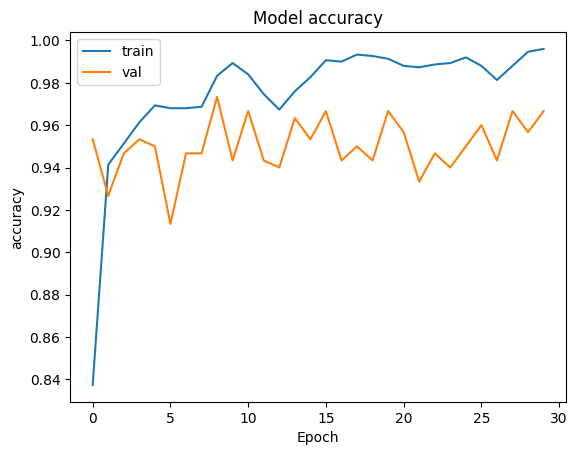

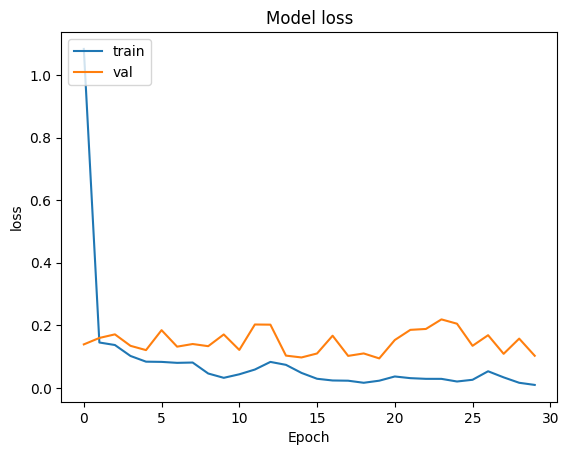

In [17]:
# Plot the training and validation accuracy and loss
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('Graph.png')
    plt.show()

# Plot accuracy and loss graphs
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

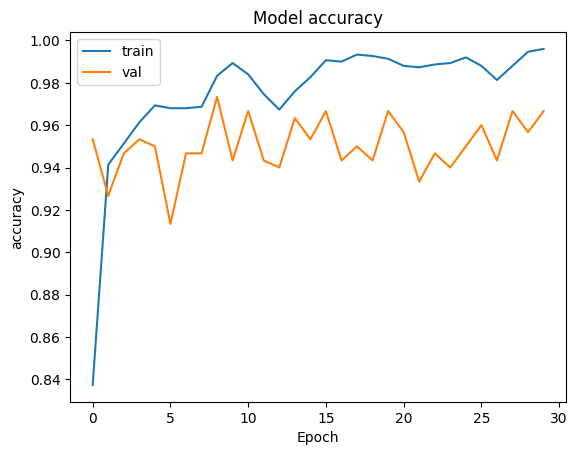

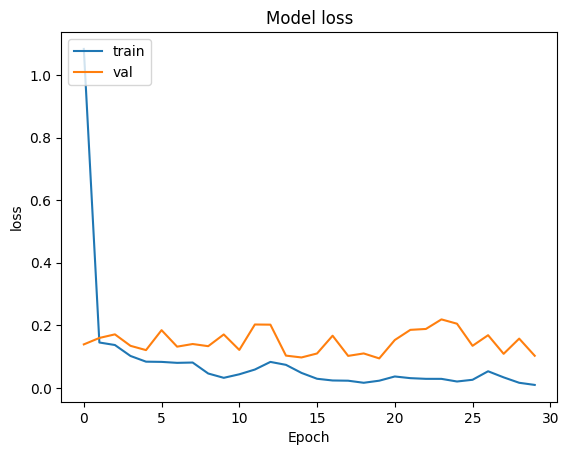

In [18]:
import matplotlib.pyplot as plt

# Function to plot and save graphs
def plot_graphs(history, metric, filename):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(filename)
    plt.show()

# Plot and save accuracy and loss graphs
plot_graphs(history, 'accuracy', 'accuracy_plot.png')
plot_graphs(history, 'loss', 'loss_plot.png')


In [19]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

10/10 [==============================] - 241s 24s/step - loss: 0.1024 - accuracy: 0.9667
Validation Loss: 0.10243567079305649
Validation Accuracy: 0.9666666388511658


In [37]:
import numpy as np # Generate predictions on the validation set
y_true = validation_generator.classes  # True labels
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=3)


10/10 [==============================] - 302s 30s/step


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from itertools import cycle
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))


                    precision    recall  f1-score   support

    adenocarcinoma       0.35      0.35      0.35       100
            benign       0.33      0.33      0.33       100
squamous_carcinoma       0.34      0.34      0.34       100

          accuracy                           0.34       300
         macro avg       0.34      0.34      0.34       300
      weighted avg       0.34      0.34      0.34       300



In [33]:
# Plot and save confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, filename):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(filename)
    plt.show()

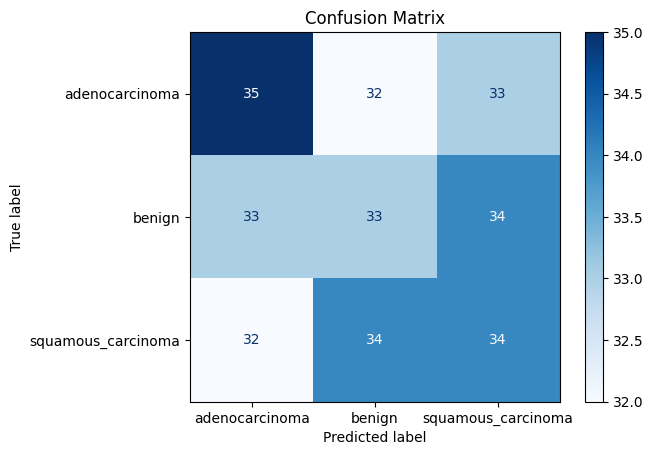

In [35]:
# Class labels
labels = list(validation_generator.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, labels, 'confusion_matrix.png')


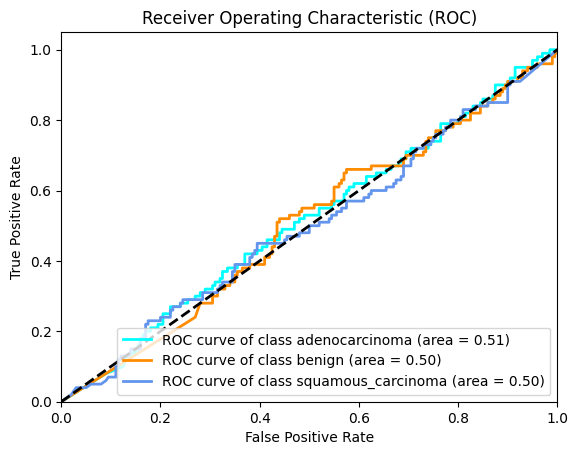

In [36]:
# Plot ROC curves
def plot_roc(y_true, y_pred, n_classes, filename):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# Plot and save ROC curves
plot_roc(y_true_categorical, y_pred, n_classes=3, filename='roc_curves.png')
